Simple BoM rainfall grids example Notebook

### Loads surface rainfall grids from the data cube. Created by Vanessa Newey

In [30]:
#for writing to error files:
from __future__ import print_function
#get some libraries
import datacube
import xarray as xr
from datacube.storage import masking
#from datacube.storage.masking import mask_to_dict #think this is obsolete
import json
import pandas as pd
import shapely
from shapely.geometry import shape
import numpy as np #need this for pq fuser

#libraries for polygon and polygon mask
import fiona
import shapely.geometry
import rasterio.features
import rasterio
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser
from datacube.storage.masking import mask_invalid_data

#dealing with system commands
import sys
import os.path

import matplotlib.pyplot as plt

#suppress warnings thrown when using inequalities in numpy (the threshold values!)
import warnings

def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)

In [31]:
def load_rainfall(query):
    
    dc_rf =datacube.Datacube(config='/g/data/r78/bom_grids/rainfall.conf')
    
    rf_data = dc_rf.load(product = 'rainfall_grids_1901_2017',**query)

    return rf_data

## Enter input shapefile and start and end date

In [32]:
#code to work with a polygon input
shape_file = ('/g/data/r78/vmn547/GWandDEA_bex_ness/Little_GW_AOI_for_demo/kEEP_ord/KEEP_AOI.shp')

In [33]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Define temporal range
start_of_epoch = '2011-01-01'
end_of_epoch =  '2011-12-31'


In [34]:
if True:
    shapes = fiona.open(shape_file)
    #i is the index of the shape file we have chosen
    i =0 
    #copy attributes from shapefile and define shape_name
    geom_crs = geometry.CRS(shapes.crs_wkt)
    geo = shapes[i]['geometry']
    geom = geometry.Geometry(geo, crs=geom_crs)
    
    query = {
        'time': (start_of_epoch, end_of_epoch), 'geopolygon': geom
    }
    
    # an alternative simple query 
    query2 = {
        'time': ('2007-01-01', '2017-12-01'), x=(149.25, 149.5), y=(-36.25, -36.5)
    }
    
    #load rainfall data (see function above)
    rf=load_rainfall(query)



In [35]:
#calculate the average across each time slice
rf_average = rf.rainfall.mean(dim =('longitude','latitude'))

#calcuate the Mean Daily Rainfall for each Month
rf_mnthy_mean = rf_average.resample('1M', dim='time',how='mean')

#calcuate the Total Rainfall for each Month
rf_mnthy_tot = rf_average.resample('1M', dim='time',how='sum')


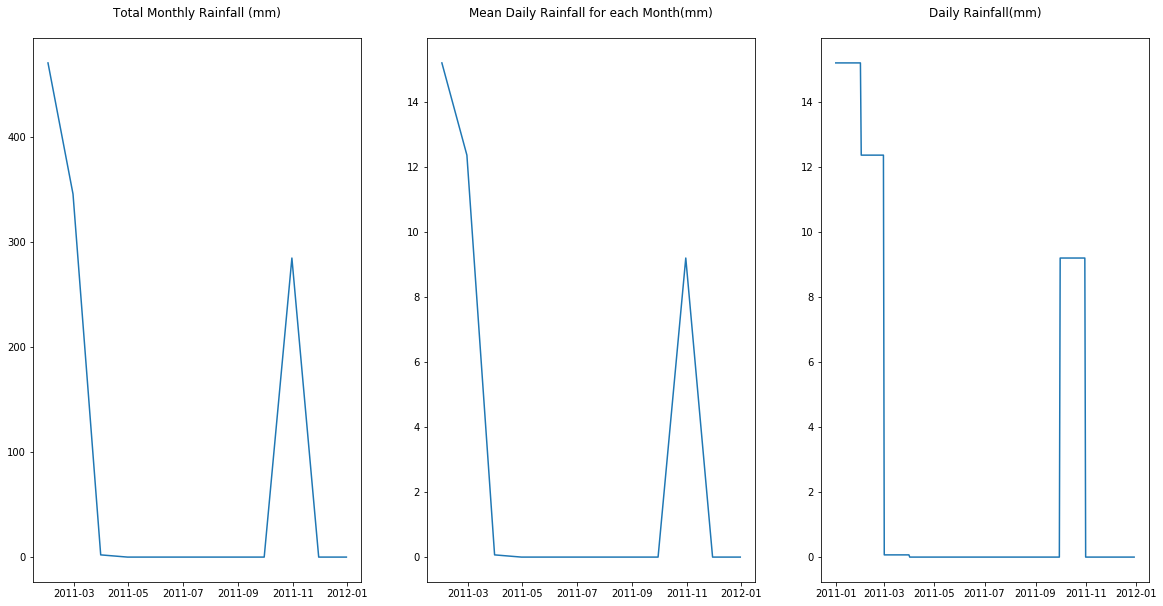

In [36]:
#plot them
import matplotlib.dates as mdates
#plt.close('all')
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(20,10))


ax1.plot(rf_mnthy_tot.time,rf_mnthy_tot.values)
# format the ticks
ax1.format_xdata = mdates.DateFormatter('%Y-%m')
            
ax1.set_title('Total Monthly Rainfall (mm)\n')

ax2.plot(rf_mnthy_mean.time,rf_mnthy_mean.values)
# format the ticks
ax2.format_xdata = mdates.DateFormatter('%Y-%m')
            
ax2.set_title('Mean Daily Rainfall for each Month(mm)\n')

ax3.plot(rf_average.time,rf_average.values)
# format the ticks
ax3.format_xdata = mdates.DateFormatter('%Y-%m')
            
ax3.set_title('Daily Rainfall(mm)\n')

plt.show()